In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

In [3]:
# AdaBoost M1 Implementation. Source: https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50

<div align = "center">

--- 
## Overview of AdaBoost
---
</div>

AdaBoost, which stands for Adaptive Boosting, is a type of ensemble learning technique applied in machine learning used to solve both classification and regression problems. It consists on a sequential training approach where a series of weak classifiers are trained on the dataset. Therefore, with each iteration, the algorithm increases the focus on data points that were previously predicted incorrectly.

As a result, the AdaBoost algorithm builds a model by considering all the individual weak classifiers which are weighted based on their performance. Classifiers with higher predictive accuracy contribute more to the final decision which reduces the influence of less accurate classifiers in the final prediction.

---
### Algorithm 10.1 AdaBoost.M1.
---

1. Initialize the observation weights $w_i = \frac{1}{N}$, for $i = 1, 2, \dots, N$.


2. For $ m = 1 $ to $ M $:
   \
   a. Fit a classifier $ G_m(x) $ to the training data using weights $ w_i $
   \
   b. Compute
      $$
      \text{err}_m = \frac{ \sum_{i=1}^N w_i I(y_i \neq G_m(x_i)) }{ \sum_{i=1}^N w_i }
      $$
   c. Compute $ \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right) $
   \
   \
   d. Set $ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $, for $ i = 1, 2, \dots, N $.

4. Output $ G(x) = \text{sign}\left( \sum_{m=1}^M \alpha_m G_m(x) \right) $.


> Source: The Elements of Statistical Learning, ch. 10

AdaBoost techniques combine many weak machine-learning models to create a powerful classification model for the output. The steps to build and combine these models are as 

1. Initialize the weights:
    - For a dataset with $N$ training data points instances, initialize $N W_{i}$ weights for each data point with $W_{i} = \frac{1}{N}$

<p></p>

2. Train weak classifiers:
    - Train a weak classifier $M_k$ where $k$ is the current iteration
    - The weak classifier we are training should have an accuracy greater than 0.5 which means it should be performing better than a naive guess

<p></p>

3. Calculate the error rate and importance of each weak model $M_k$
    - Calculate rate $error\_rate$ for every weak classifier $M_k$ on the training dataset
    - Calculate the importance of each model $α\_k$ using formula $\alpha_k = \frac{1}{2} \ln{\frac{1 – error_k}{error_k}}$

<p></p>

4. Update data point weight for each data point $W_i$:
    - After applying the weak classifier model to the training data we will update the weight assigned to the points using the accuracy of the model. The formula for updating the weights will be $w_i = w_i \exp{(-\alpha_k y_i M_k(x_i))}$. Here $y_i$ is the true output and $X_i$ is the corresponding input vector

<p></p>

5. Normalize the Instance weight:
    - We will normalize the instance weight so that they can be summed up to 1 using the formula $W_i = W_i / sum(W)$

<p></p>

6. Repeat steps 2-5 for $K \space iterations$
    - We will train $K \space classifiers$ and will calculate model importance and update the instance weights using the above formula
    - The final model $M(X)$ will be an ensemble model which is obtained by combining these weak models weighted by their model weights 

In [4]:
# Compute error rate, alpha and w
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation
    
    Note that all arrays should be the same length
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [12]:
# Define AdaBoost class
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [6]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# Fit model
ab = AdaBoost()
ab.fit(X_train, y_train, M = 400)

# Predict on test set
y_pred = ab.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.8621


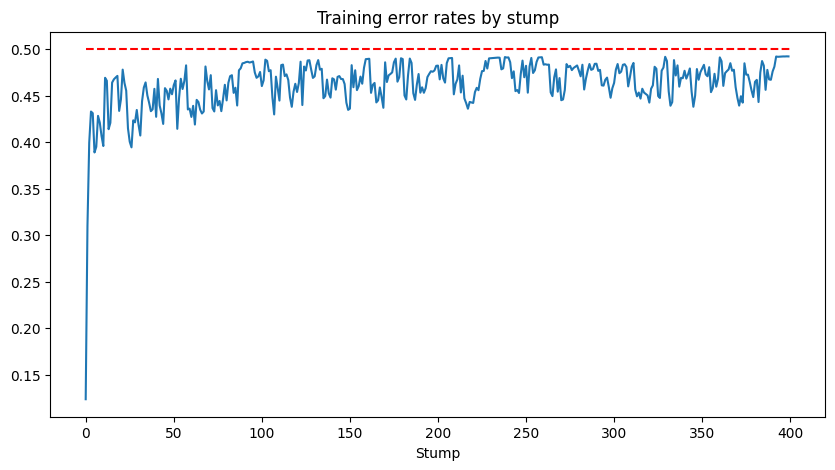

In [8]:
# Error rates during training
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()